In [8]:
# !pip install langchain langgraph cassio

In [20]:
# {
#   "clientId": "xHmOoYZBnWEEhlWdGADPPIiO",
#   "secret": "JkOT_S660wu+8H1+NlPDuX49JjZZLMZHPzyqylZZ48Qrtg2hr0odlZmxQF.GFrDUDfMCv2uFTra8DtiC7Lhj+vWs1EQlpG.h73K3KGs4SRSRn4HOHUFfUYBa,JxJWbXZ",
#   "token": "AstraCS:xHmOoYZBnWEEhlWdGADPPIiO:cffb7d9391249f5ab0080e55bce8e0252ef67b1c2e2c3b159644a22433df21a9"
# }c01f0573-9816-4932-9330-7fddf4298e49

In [21]:
import cassio
## connection of the ASTRA DB
ASTRA_DB_APPLICATION_TOKEN="AstraCS:xHmOoYZBnWEEhlWdGADPPIiO:cffb7d9391249f5ab0080e55bce8e0252ef67b1c2e2c3b159644a22433df21a9"
ASTRA_DB_ID="c01f0573-9816-4932-9330-7fddf4298e49"
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [22]:
# !pip install langchain_community

In [23]:
# !pip install -U langchain_community tiktoken langchain-groq langchainhub chromadb langchain langgraph langchain_huggingface

In [24]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)



In [25]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [31]:
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

In [32]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [33]:
retriever=astra_vector_store.as_retriever()

In [34]:
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

[Document(id='33b7439642394695821f1e5a0b97102e', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context lear

In [ ]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
import os
from dotenv import load_dotenv
load_dotenv()
# from google.colab import userdata
# LLM with function call
from langchain_groq import ChatGroq


# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

groq_api_key=os.getenv('GROQ_API_KEY')

# os.environ["GROQ_API_KEY"]=groq_api_key
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='wiki_search'
datasource='vectorstore'


In [42]:
# !pip install langchain_community
# !pip install arxiv wikipedia

In [43]:
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [58]:
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [59]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [69]:
# def wiki_search(state):
#     """
#     wiki search based on the re-phrased question.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         state (dict): Updates documents key with appended web results
#     """

#     print("---wikipedia---")
#     print("---HELLO--")
#     question = state["question"]
#     print(question)

#     # Wiki search
#     docs = wiki.invoke({"query": question})
#     #print(docs["summary"])
#     wiki_results = docs
#     wiki_results = Document(page_content=wiki_results)

#     return {"documents": wiki_results, "question": question}
# In Cell 46

from langchain.schema import Document

def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WIKIPEDIA SEARCH---")
    question = state["question"]
    print(f"Searching Wikipedia for: {question}")

    # Wiki search
    docs = wiki.invoke({"query": question})
    wiki_results = Document(page_content=docs) # Wrap the result in a Document

    return {"documents": [wiki_results], "question": question} # Return as a list

In [70]:
# ### Edges ###


# def route_question(state):
#     """
#     Route question to wiki search or RAG.

#     Args:
#         state (dict): The current graph state

#     Returns:
#         str: Next node to call
#     """

#     print("---ROUTE QUESTION---")
#     question = state["question"]
#     source = question_router.invoke({"question": question})
#     if source.datasource == "wiki_search":
#         print("---ROUTE QUESTION TO Wiki SEARCH---")
#         return "wiki_search"
#     elif source.datasource == "vectorstore":
#         print("---ROUTE QUESTION TO RAG---")
#         return "vectorstore"
# In Cell 47

def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]

    # Add a simple rule-based check for short queries/acronyms
    if len(question) <= 3:
        print("---QUERY IS SHORT, ROUTING TO WIKIPEDIA---")
        return "wiki_search"

    # Otherwise, use the LLM-based router
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO WIKI SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [71]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [72]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

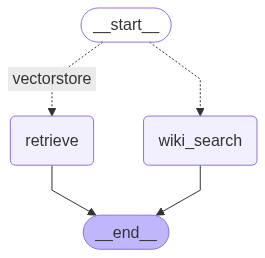

In [73]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [74]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do self-criticism and '
 'self-reflection over past actions, learn from mistakes and refine them for '
 'future steps, thereby improving the quality of final res

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15104\2686642801.py:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [76]:
from pprint import pprint

# Run
inputs = {
    "question": "Shah RUkh Khan"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
[Document(id='6cecf5c94a974556990c1c98eed43766', metadata={'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality

# RELEVANCE CHECKER

In [77]:
### Grade Documents ###
from langchain_core.pydantic_v1 import BaseModel, Field

# Data model for the grader
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appends grade to state
    """
    print("---CHECK DOCUMENT RELEVANCE---")
    question = state["question"]
    documents = state["documents"]

    # LLM with function call
    llm = ChatGroq(model_name="Gemma2-9b-It", temperature=0)
    structured_llm_grader = llm.with_structured_output(GradeDocuments)

    # Prompt
    system = """You are a grader assessing relevance of a retrieved document to a user question.
    If the document contains keywords related to the user question, grade it as relevant.
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals.
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
    grade_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
        ]
    )

    retrieval_grader = grade_prompt | structured_llm_grader
    score = retrieval_grader.invoke({"question": question, "document": documents[0].page_content})
    grade = score.binary_score

    if grade == "yes":
        print("---DECISION: DOCS ARE RELEVANT---")
    else:
        print("---DECISION: DOCS ARE NOT RELEVANT---")

    return {"documents": documents, "question": question, "grade": grade}

### Generate Answer ###
def generate(state):
    """
    Generate answer using the LLM.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appends generation to state
    """
    print("---GENERATE ANSWER---")
    question = state["question"]
    documents = state["documents"]
    
    # LLM
    llm = ChatGroq(model_name="Gemma2-9b-It", temperature=0)
    
    # Prompt
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", "You are an expert Q&A assistant. Use the following context to answer the user's question. If you don't know, just say that you don't know."),
            ("human", "Context: \n\n {context} \n\n Question: \n {question}"),
        ]
    )

    rag_chain = prompt | llm
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation.content}

In [78]:
### Conditional Edge ###
def decide_to_generate(state):
    """
    Determines whether to generate an answer or fall back to web search.

    Args:
        state (dict): The current graph state

    Returns:
        str: "generate" or "wiki_search"
    """
    print("---ASSESS GRADED DOCUMENTS---")
    grade = state.get("grade")

    if grade == "yes":
        print("---DECISION: GENERATE---")
        return "generate"
    else:
        print("---DECISION: WIKI SEARCH---")
        return "wiki_search"

In [79]:
from langgraph.graph import END, StateGraph, START

# Redefine the GraphState to include the new 'grade' and 'generation' fields
class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    question: str
    generation: str
    documents: List[Document] # Use Document type for consistency
    grade: str

# Build the new workflow
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("wiki_search", wiki_search)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "generate": "generate",
        "wiki_search": "wiki_search",
    },
)
workflow.add_edge("wiki_search", "generate") # Route wiki results to the generator
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

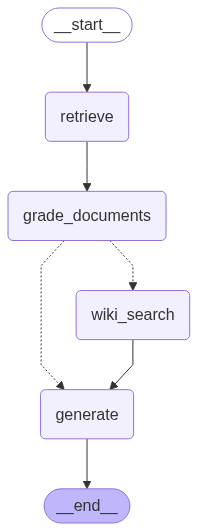

In [80]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [81]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE---
---DECISION: DOCS ARE RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
"Node 'grade_documents':"
'\n---\n'
---GENERATE ANSWER---
"Node 'generate':"
'\n---\n'
('Building agents with LLM (large language model) as its core controller is a '
 'cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer '
 'and BabyAGI, serve as inspiring examples. The potentiality of LLM extends '
 'beyond generating well-written copies, stories, essays and programs; it can '
 'be framed as a powerful general problem solver.\n'
 'Agent System Overview\n'
 'In a LLM-powered autonomous agent system, LLM functions as the agent’s '
 'brain, complemented by several key components:\n'
 '\n'
 'Planning\n'
 '\n'
 'Subgoal and decomposition: The agent breaks down large tasks into smaller, '
 'manageable subgoals, enabling efficient handling of complex tasks.\n'
 'Reflection and refinement: The agent can do 

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15104\2686642801.py:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [88]:
from pprint import pprint

# Run
inputs = {
    "question": "DDLJ"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE---
---DECISION: DOCS ARE NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: WIKI SEARCH---
"Node 'grade_documents':"
'\n---\n'
---WIKIPEDIA SEARCH---
Searching Wikipedia for: DDLJ
"Node 'wiki_search':"
'\n---\n'
---GENERATE ANSWER---
"Node 'generate':"
'\n---\n'
[Document(metadata={}, page_content='Page: Dilwale Dulhania Le Jayenge\nSummary: Dilwale Dulhania Le Jayenge (transl.\u2009The Brave-Hearted Will Take the Bride), also known by the initialism DDLJ, is a 1995 Indian Hindi-language musical roman')]
